In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sequence_jacobian import simple, create_model

## Question 2 - Sequence Space

In [2]:
from sequence_jacobian import simple, create_model

@simple
def market_clear(gamma, beta, theta, epsil, w, y, p, q, a, n, f1, f2):
    mu = 1/(epsil - 1)
    pi = p/p(-1)
    r = q/(p(+1)/p)
    c = y
    resf1 = (1+mu)*y*w/(p * a) + beta*theta*(pi(+1)**epsil)*(c(+1)**(-gamma))*(c**(gamma))*f1(+1)-f1
    resf2 = y + beta*theta*(pi(+1))**(epsil-1)*((c(+1))**(-gamma))*(c**gamma)*f2(+1)-f2
    b = f1/f2 
    pstar = b*p
    euler = beta * c(+1)**(-gamma) * q * (p / p(+1)) - c**(-gamma)
    res = (1-theta) * b**(1-epsil) + theta*(pi**(epsil-1))-1
    return euler, res, resf1, resf2, r, c, b, pstar, pi

@simple
def monetary_policy(beta, phi_pi, v, p):
    pi = p/p(-1)
    q = 1/beta*(pi**phi_pi)*(2.7182818284590452353602874)**v
    return q

@simple
def wage(chi, varphi, gamma, y, n, p, a):
    c = y
    w = (chi * n**varphi * c**gamma) * p
    mc = (p*a)/w
    return w, mc


@simple
def production(a, n, varphi, gamma):
    yflex = (1+varphi)/(gamma+varphi) * a
    y = a * n
    y_gap = y - yflex
    return y, yflex, y_gap
    

In [3]:
nlnk = create_model([production, wage, monetary_policy, market_clear], name="NLNK")

print(nlnk)
print(f"Blocks: {nlnk.blocks}")

<Model 'NLNK'>
Blocks: [<SimpleBlock 'monetary_policy'>, <SimpleBlock 'production'>, <SimpleBlock 'wage'>, <SimpleBlock 'market_clear'>]


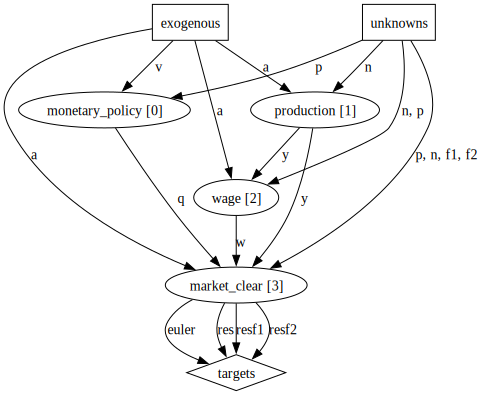

In [4]:
from sequence_jacobian.utilities.drawdag import drawdag

unknowns = ['p', 'n', 'f1', 'f2']
targets = ['euler', 'res', 'resf1', 'resf2']
inputs = ['a', 'v']

drawdag(nlnk, inputs, unknowns, targets, save="nlnk.png")

In [5]:
# initial parameters
beta    = 0.99
sigma   = 1
kappa   = 0.1
rho_a   = 0.8
sigma_a = 0.01
phi_pi  = 1.5
gamma   = 1/sigma
varphi  = 1
v       = 0
chi     = 1
epsil   = 10
phi_y   = 0
mu      = 1/(epsil - 1)
theta   = 0.5
# steady state values
calibration = {'a': 1, 'v': 0, 'yflex': 1, 'y': np.sqrt(1/(1+mu)), 'c': np.sqrt(1/(1+mu)), 'pstar': 1, 
               'w': 1/(1+mu), 'q': 1/beta, 'mu': mu, 'varphi': varphi, 'chi':chi,
               'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'kappa': kappa, 'epsil':epsil}

# solve for steady state 
unknowns_ss = {'p': 1, 'n': np.sqrt(1/(1+mu)), 
               'f1':np.sqrt(1/(1+mu))/(1-(beta*theta)), 
               'f2': np.sqrt(1/(1+mu))/(1-(beta*theta))}
targets_ss  = { "euler": 0., "res": 0., "resf1": 0., "resf2": 0.}

In [ ]:
theta_list = [0.0001, 0.25, 0.5, 0.75, 0.9999]
ss_list    = []
G_list     = []

for theta in theta_list:
    calibration_tmp = calibration.copy()
    calibration_tmp['theta'] = theta
    unknowns_ss['f1'] = np.sqrt(1/(1+mu))/(1-(beta*theta)) 
    unknowns_ss['f2'] = np.sqrt(1/(1+mu))/(1-(beta*theta))

    # calculate new steady state
    ss_tmp = nlnk.solve_steady_state(calibration_tmp, unknowns_ss, targets_ss, solver="broyden_custom")
    
    # calculate new Jacobian
    G_tmp = nlnk.solve_jacobian(ss_tmp, unknowns, targets, inputs, T=300)
    
    ss_list.append(ss_tmp)
    G_list.append(G_tmp)

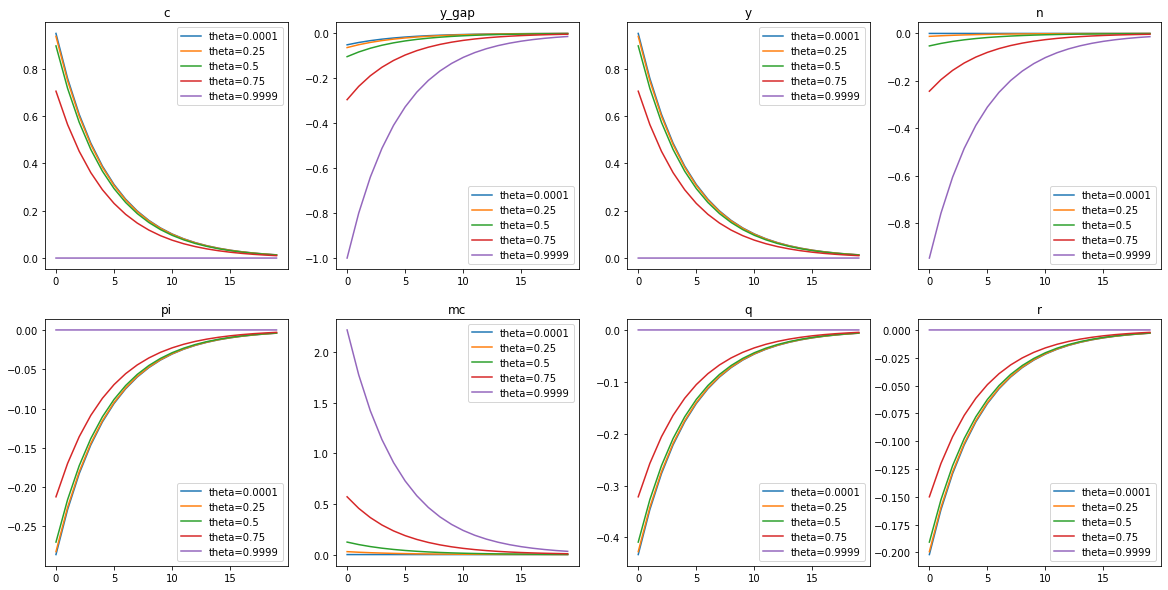

In [7]:
T, Tplot, impact, news = 300, 20, 0.01, 10
da = np.empty((T, 1))
da[:, 0] = impact * rho_a**np.arange(T)

# plot responses for shock, nominal interest rate, real interest rate, inflation, output, and employment
plotset = ['c', 'y_gap', 'y', 'n', 'pi', 'mc', 'q', 'r']
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, var in enumerate(plotset):
    if var == 'a':
        irf1 = da[:Tplot]
        irf2 = da[:Tplot]
        irf3 = da[:Tplot]
        irf4 = da[:Tplot]
        irf5 = da[:Tplot]
    else:
        irf1 = 100 * (G_list[0][var]['a'] @ da)[:Tplot]
        irf2 = 100 * (G_list[1][var]['a'] @ da)[:Tplot]
        irf3 = 100 * (G_list[2][var]['a'] @ da)[:Tplot]
        irf4 = 100 * (G_list[3][var]['a'] @ da)[:Tplot]
        irf5 = 100 * (G_list[4][var]['a'] @ da)[:Tplot]
        
    axi = ax[i // 4, i % 4]
    axi.plot(irf1, label="theta=0.0001")
    axi.plot(irf2, label="theta=0.25")
    axi.plot(irf3, label="theta=0.5")
    axi.plot(irf4, label="theta=0.75")
    axi.plot(irf5, label="theta=0.9999")
    
    axi.set_title(f"{var}")
    axi.xlabel = "quarters"
    axi.ylabel = "% deviation"
    axi.legend()

plt.savefig("q2g.png", dpi=300)